# Season recognition

The goal of this project is to develop a model that will classify the season on the picture. I compared number of machine learining algorithms with state-of-the-art transfer learning to achieve best accuracy score.   

### Basic Dependencies

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
keras.__version__

'2.2.4'

### Google collabolatory virtual drive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Machine learning

### Importing Data

As a input to our ML we'll be using real colour pictures rescaled to 256x256 pixels. It gives us input vector of 196 608 variables

In [0]:
seasons = ['Spring', 'Winter', 'Summer', 'Fall']
path = '/content/drive/My Drive/Kaggle/Season recognition/Data'

In [0]:
def image_to_array(path_to_img):
  tmp = Image.open(path_to_img)
  tmp = tmp.resize((256,256))
  tmp = np.array(tmp)
  if tmp.shape[2] == 4:
    tmp = np.delete(tmp,3,2)
  out = tmp.reshape([1,-1])
  return np.array(out)

In [0]:
train_data = []
y_train = []
for i in range(len(seasons)):
  print("Season: " + seasons[i])
  pictures = os.listdir(path+f'/Train/{seasons[i]}')
  train_data.append(image_to_array(path+f'/Train/{seasons[i]}/'+pictures[0]))
  y_train.append(np.array([f'{seasons[i]}'] * len(pictures)).reshape([-1,1]))
  for j in range(1, len(pictures)):
    print(j)
    train_data[i] = np.vstack((train_data[i], image_to_array(path+f'/Train/{seasons[i]}/'+pictures[j])[0]))

In [0]:
test_data = []
y_final = []
for i in range(len(seasons)):
  print("Season: " + seasons[i])
  pictures = os.listdir(path+f'/Test/{seasons[i]}')
  test_data.append(image_to_array(path+f'/Test/{seasons[i]}/'+pictures[0]))
  y_final.append(np.array([f'{seasons[i]}'] * len(pictures)).reshape([-1,1]))
  for j in range(1, len(pictures)):
    print(j)
    test_data[i] = np.vstack((test_data[i], image_to_array(path+f'/Test/{seasons[i]}/'+pictures[j])[0]))

In [0]:
train_data = np.vstack(train_data)
y_train = np.vstack(y_train)
test_data = np.vstack(test_data)
y_final = np.vstack(y_final)

### Principal Component Analysis

Because of high numer of variables, we are using popular PCA algorithm to reduce dimensionality

In [0]:
from sklearn.decomposition import PCA
pca = PCA()

In [0]:
pca.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca.components_.shape

(402, 196608)

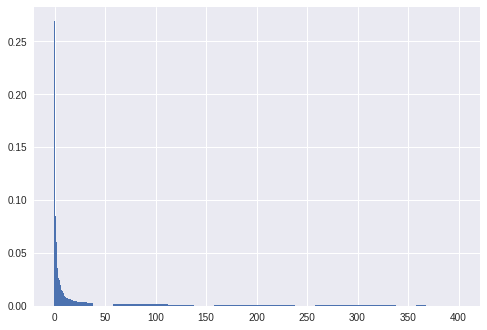

In [0]:
plt.bar(range(pca.n_components_),pca.explained_variance_ratio_)
plt.show()

Number of components that have explained variance ratio higher than 1%

In [0]:
sum(pca.explained_variance_ratio_ > 0.01)

10

In [0]:
pca = PCA(10)
pca.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

We use pca model trained on train data to prevent information leak

In [0]:
train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, y_train, test_size=0.33, random_state=99)

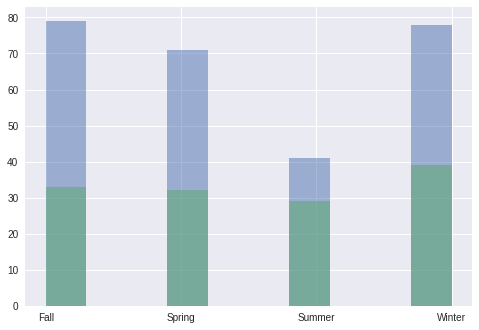

In [0]:
plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

In [0]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed)

### Linear SVC

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

param_grid_1 = {'C': [0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500]}

grid_1 = GridSearchCV(LinearSVC(multi_class="ovr"), param_grid_1, cv=kfold, 
                      return_train_score=True, n_jobs = -1, verbose = 1)

grid_1.fit(X_train, y_train.ravel())
grid_1.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'C': 0.1}

### Rbf SVC

In [0]:
from sklearn.svm import SVC

param_grid_2 = {'C': [10 ** -9, 10 ** -8, 10 ** -7, 10 ** -6, 10 ** -5, 10 ** -4],
              'gamma': [10 ** -7, 10 ** -6, 10 ** -5, 10 ** -4, 10 ** -3]}

grid_2 = GridSearchCV(SVC(C=1, probability=True), param_grid_2, cv=kfold, 
                      return_train_score=True, n_jobs = -1, verbose = 1)

grid_2.fit(X_train, y_train.ravel())
grid_2.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.3s finished


{'C': 1e-09, 'gamma': 1e-07}

### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

param_grid_3 = {'C': [10 ** -9, 10 ** -8, 10 ** -7, 10 ** -6, 10 ** -5, 10 ** -4],
              'penalty': ['l1', 'l2']}

grid_3 = GridSearchCV(LogisticRegression(C=1), param_grid_3, cv=kfold, 
                      return_train_score=True, n_jobs = -1, verbose = 1)

grid_3.fit(X_train, y_train.ravel())
grid_3.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


{'C': 1e-08, 'penalty': 'l2'}

### KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_4 = {
            'n_neighbors': [2, 5, 10, 11,12],
            'metric': ['euclidean', 'cityblock', 'cosine']
}

grid_4 = GridSearchCV(KNeighborsClassifier(n_neighbors=2, metric='euclidean'), 
                      param_grid_4, cv=kfold, 
                      return_train_score=True, n_jobs = -1, verbose = 1)

grid_4.fit(X_train, y_train.ravel())
grid_4.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'metric': 'euclidean', 'n_neighbors': 11}

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

param_grid_5 = {
              'n_estimators': [10, 50, 100, 200, 300],
              'max_leaf_nodes': [10, 20, 30, 40, 50, 60],
              'max_depth': [4, 5, 8,10, 20, 30]
             }


grid_5 = GridSearchCV(RandomForestClassifier(n_estimators=50, max_leaf_nodes=16), 
                      param_grid_5, cv=kfold, 
                      return_train_score=True, n_jobs = -1, verbose = 1)

grid_5.fit(X_train, y_train.ravel())
grid_5.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 499 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 849 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 20, 'max_leaf_nodes': 50, 'n_estimators': 200}

### Extra Trees

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

param_grid_6 = {
              'n_estimators': [10, 50, 100, 200, 300],
              'max_leaf_nodes': [10, 20, 30, 40, 50, 60],
              'max_depth': [4, 5, 8,10, 20, 30]
             }


grid_6 = GridSearchCV(ExtraTreesClassifier(n_estimators=50, max_leaf_nodes=16), 
                      param_grid_6, cv=kfold, 
                      return_train_score=True, n_jobs = -1, verbose = 1)

grid_6.fit(X_train, y_train.ravel())
grid_6.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 8, 'max_leaf_nodes': 60, 'n_estimators': 200}

### XGBoost

In [0]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

param_grid_7 = {
              'n_estimators': [10,20, 30, 40, 50, 100],
              'learning_rate': [0.1, 0.2,0.5,0.9, 1]
             }

grid_7 = GridSearchCV(xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42), 
                      param_grid_7, cv=kfold, 
                      return_train_score=True, n_jobs = -1, verbose = 1)

grid_7.fit(X_train, y_train.ravel())
grid_7.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.9, 'n_estimators': 10}

### Classification Metrics

In [0]:
from sklearn import  metrics


models = []
models.append(('SVM linear', grid_1.best_estimator_))
models.append(('SVM rbf', grid_2.best_estimator_))
models.append(('LR', grid_3.best_estimator_))
models.append(('KNN', grid_4.best_estimator_))
models.append(('RF', grid_5.best_estimator_))
models.append(('ExtraTrees', grid_6.best_estimator_))
models.append(('XGBoost', grid_7.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_final , model.predict(test_data,), average = "weighted" ) ))
    print("recall_score: {}".format( metrics.recall_score(y_final , model.predict(test_data), average = "weighted") ))
    print("f1_score: {}".format( metrics.f1_score(y_final , model.predict(test_data), average = "weighted") ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_final , model.predict(test_data)) ))

    precision_score.append(metrics.precision_score(y_final , model.predict(test_data), average = "weighted"))
    recall_score.append(metrics.recall_score(y_final , model.predict(test_data), average = "weighted"))
    f1_score.append( metrics.f1_score(y_final , model.predict(test_data), average = "weighted"))
    accuracy_score.append(metrics.accuracy_score(y_final , model.predict(test_data)))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM linear
precision_score: 0.4267556099239268
recall_score: 0.44554455445544555
f1_score: 0.41953007241022605
accuracy_score: 0.44554455445544555
SVM rbf
precision_score: 0.07146358200176453
recall_score: 0.26732673267326734
f1_score: 0.11277846534653466
accuracy_score: 0.26732673267326734
LR
precision_score: 0.6176867686768677
recall_score: 0.6237623762376238
f1_score: 0.5678211629961734
accuracy_score: 0.6237623762376238
KNN
precision_score: 0.6524952900148315
recall_score: 0.6336633663366337
f1_score: 0.6013003857930551
accuracy_score: 0.6336633663366337
RF
precision_score: 0.6267113302488451
recall_score: 0.6237623762376238
f1_score: 0.5708823357108539
accuracy_score: 0.6237623762376238
ExtraTrees
precision_score: 0.4599270453361125
recall_score: 0.5841584158415841
f1_score: 0.49196496572734194
accuracy_score: 0.5841584158415841
XGBoost
precision_score: 0.72869385152801
recall_score: 0.6831683168316832
f1_score: 0.6505116939896443
accuracy_score: 0.6831683168316832


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM linear', 'SVM rbf', 'LR', 'KNN', 
                                         'RF', 'ExtraTrees','XGBoost'])
df

,Method,accuracy_score,f1_score,precision_score,recall_score
0,SVM linear,0.445545,0.419530,0.426756,0.445545
1,SVM rbf,0.267327,0.112778,0.071464,0.267327
2,LR,0.623762,0.567821,0.617687,0.623762
3,KNN,0.633663,0.601300,0.652495,0.633663
4,RF,0.623762,0.570882,0.626711,0.623762
5,ExtraTrees,0.584158,0.491965,0.459927,0.584158
6,XGBoost,0.683168,0.650512,0.728694,0.683168


# Transfer Learning

### Preparing data generators that will feed the algorithm

In [0]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Kaggle/Season recognition/Data/Train',
    batch_size=32,
    class_mode = 'categorical',
    target_size=(256,256))

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Kaggle/Season recognition/Data/Test',
    shuffle=True,
    class_mode = 'categorical',
    target_size=(256,256))

Found 399 images belonging to 4 classes.
Found 99 images belonging to 4 classes.


### ResNet50

We are using highly-efficient ResNet50 network as a base for our model. We won't change weights of this network during training iterations

In [0]:
transfer_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in transfer_base.layers:
    layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 8s 0us/step


### Top layers

We are using Global Average Pooling and simple dense layer with 512 neurons. To prevent overfitting we apply 0.5 dropout on top of the dense layer.

In [0]:
x = transfer_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
prediction_layer = layers.Dense(4, activation='softmax')(x)

In [0]:
model = Model(transfer_base.input, prediction_layer)

In [0]:
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

In [0]:
history = model.fit_generator(generator=train_generator,
                              epochs=10,
                              steps_per_epoch=32)

Epoch 1/10
32/32 [==============================] - 65s 2s/step - loss: 0.0519 - categorical_accuracy: 0.9802
Epoch 2/10
32/32 [==============================] - 68s 2s/step - loss: 0.0296 - categorical_accuracy: 0.9912
Epoch 3/10
32/32 [==============================] - 66s 2s/step - loss: 0.0287 - categorical_accuracy: 0.9892
Epoch 4/10
32/32 [==============================] - 69s 2s/step - loss: 0.0274 - categorical_accuracy: 0.9873
Epoch 5/10
32/32 [==============================] - 65s 2s/step - loss: 0.0377 - categorical_accuracy: 0.9891
Epoch 6/10
32/32 [==============================] - 66s 2s/step - loss: 0.0516 - categorical_accuracy: 0.9814
Epoch 7/10
32/32 [==============================] - 68s 2s/step - loss: 0.0385 - categorical_accuracy: 0.9912
Epoch 8/10
32/32 [==============================] - 67s 2s/step - loss: 0.0324 - categorical_accuracy: 0.9932
Epoch 9/10
32/32 [==============================] - 67s 2s/step - loss: 0.0296 - categorical_accuracy: 0.9931
Epoch 10/1

In [0]:
model.evaluate_generator(test_generator, steps = 30)

[0.3312851121064224, 0.8982826948480845]

### Summary

As we can see, the convolutional neural network 
significantly outperforms classic machine learning algorithms. It is caused by the fact, that convolutional neural networks make the image processing computationally manageable through filtering the connections by proximity. Each neuron is responsible for processing only a certain portion of an image. 